In [ ]:
import os
import math
import time
import cv2

import numpy as np
import numpy.matlib
import numpy.linalg
import numba

import joblib
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.utils import np_utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##########################################load codebook, HONV_LLC and training model##########################################
import HONV_LLC_Library as LLC3D

bowl_3D = keras.models.load_model('3D_bowl.h5')
cereal_box_3D = keras.models.load_model('3D_cereal_box.h5')
flashlight_3D = keras.models.load_model('3D_flashlight.h5')

codebook3D = joblib.load('kmeans_HONV_1024.pkl')
centers3D = codebook3D.cluster_centers_
centers3D.shape

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(1024, 48)

In [ ]:
##########################################load codebook, HOG_LLC and training model##########################################
import HOG_LLC_Library as LLC2D
bowl = keras.models.load_model('2D_bowl.h5')
cereal_box = keras.models.load_model('2D_cereal_box.h5')
flashlight = keras.models.load_model('2D_flashlight.h5')

codebook2D = joblib.load('kmeans_HOG_512.pkl')
centers2D = codebook2D.cluster_centers_
centers2D.shape

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(512, 8)

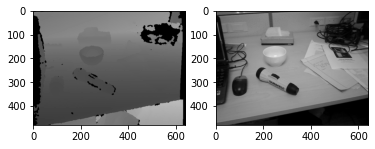

In [ ]:
############################################read img############################################
img_depth = cv2.imread('desk_depth.png', cv2.IMREAD_ANYDEPTH)
plt.subplot(1, 2, 1)
plt.imshow(img_depth, cmap="gray", vmin=0, vmax=2048)

img = cv2.imread('desk.png', cv2.IMREAD_GRAYSCALE)
plt.subplot(1, 2, 2)
plt.imshow(img, cmap="gray")
dim = img.shape

In [ ]:
############################################selective search for gray############################################
img_SS = img.copy()
img_SS = np.ravel(img_SS, order='C')
img_SS = np.transpose(np.matlib.repmat(img_SS,3,1))
img_SS = np.reshape(img_SS, (dim[0], dim[1], 3), order='C')
img_SS.shape

(480, 640, 3)

In [ ]:
############################################selective search############################################
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img_SS)
ss.switchToSelectiveSearchFast()
#ss.switchToSelectiveSearchQuality()
rects = ss.process()

In [ ]:
#######################################fliter boxes with suitalbe size out#######################################
ROI = []
img_roi = img_SS.copy()
for i, rect in enumerate(rects):
    x, y, w, h = rect
    if((180 >= w >= 40) and (180 >= h >= 40)):    #filter the box with size
        cv2.rectangle(img_roi, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        ROI.append(rects[i])
    else:
          continue
ROI = np.asarray(ROI)

num of ROI： 325


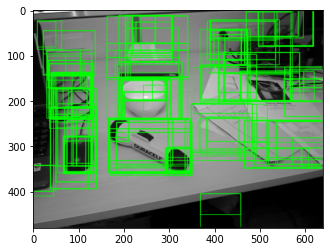

In [ ]:
print('num of ROI： {}'.format(len(ROI)))
plt.imshow(img_roi, cmap="gray", vmin=0, vmax=2048)

In [ ]:
#####################################feature extraction and classification for each ROI in 3D only#####################################
bounding_box = np.empty((0,6))
for i, rect in enumerate(ROI):
    x, y, w, h = rect
    ROI_img = img_depth[y:y+h, x:x+w] #in selective search x is width, y is height
    img_feature = LLC3D.Img_code(ROI_img, centers3D)
    img_feature = img_feature.reshape(-1,len(img_feature))

    #################################################################
    prob_0 = bowl_3D.predict_proba(img_feature)
    prob_1 = flashlight_3D.predict_proba(img_feature)
    prob_2 = cereal_box_3D.predict_proba(img_feature)
    testing_prob = np.asarray([prob_0[0,0], prob_1[0,0], prob_2[0,0]])

    category = testing_prob.argsort()[::-1][0]
    #print(category)

    score3D = testing_prob[category]
    #print(score3D)
    #################################################################

    if(score3D>=0.5):
        bounding_box = np.append(bounding_box, [[x, y, w, h, score3D, category]], axis=0)  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [ ]:
bounding_box.shape

(24, 6)

In [ ]:
BB_img = img_SS.copy()
for i, rect in enumerate(bounding_box):
    x, y, w, h = rect[0:4]
    cv2.rectangle(BB_img, (int(x), int(y)), (int(x+w), int(y+h)), (0, 0, 255), 2, cv2.LINE_AA)

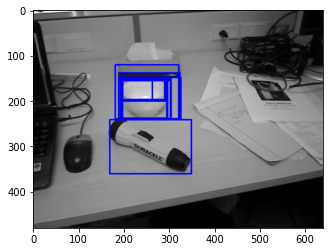

In [ ]:
plt.imshow(BB_img)

In [ ]:
#####################################Non-maximum suppression#####################################
def py_cpu_nms(dets, thresh):
    """Pure Python NMS baseline."""
    #get x1、y1、x2、y2 and score
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = x1 + dets[:, 2]
    y2 = y1 + dets[:, 3]
    scores = dets[:, 4]

    #area of each box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    #descending sort base on the score
    order = scores.argsort()[::-1]

    keep = [] #list of result
    while order.size > 0:
        i = order[0]
        keep.append(i) #store the box with highest score in the rest
        #get the intersect point
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        #intersect area
        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        #get IoU：intersect area /（area1+area2-intersect area）
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        areas_s = np.minimum(areas[i], areas[order[1:]])
        #keep boxes with IOU Less than thresh
        inds = np.where((ovr <= thresh) & (inter <= 0.7*areas_s))[0]
        order = order[inds + 1] #keep boxes in inds

    return keep

In [ ]:
index = py_cpu_nms(bounding_box, 0.3)
index = np.asarray(index)
index

array([22, 11])

In [ ]:
#####################################result#####################################
if(len(index) == 0):
    result3D = np.empty((0,6))
else:
    result3D = bounding_box[index]
result3D

array([[195.        , 151.        , 100.        ,  87.        ,
          0.99997914,   0.        ],
       [169.        , 241.        , 180.        , 119.        ,
          0.6410777 ,   1.        ]])

In [ ]:
result3D_img = img_SS.copy()
for i, rect in enumerate(result3D):
    x, y, w, h = rect[0:4]
    c = rect[5]
    if(c == 0):
        cv2.rectangle(result3D_img, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2, cv2.LINE_AA)
    elif(c == 1):
        cv2.rectangle(result3D_img, (int(x), int(y)), (int(x+w), int(y+h)), (0, 255, 0), 2, cv2.LINE_AA)
    else:
        cv2.rectangle(result3D_img, (int(x), int(y)), (int(x+w), int(y+h)), (0, 255, 255), 2, cv2.LINE_AA)

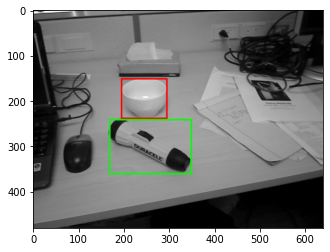

In [ ]:
plt.imshow(result3D_img)